In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import json
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from torchvision import transforms, utils
import torchvision.models as models

In [347]:
PATH = '/media/popo/Elements/Datasets/Leaf-disease-classification/'

In [348]:
label_dict = json.load(open(f'{PATH}label_num_to_disease_map.json'))
train_ids = pd.read_csv(f'{PATH}train.csv')

In [349]:
train_ids.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


<AxesSubplot:>

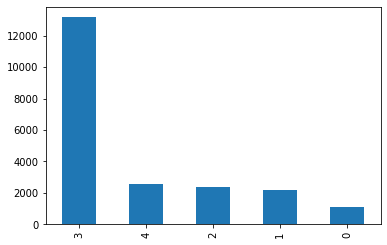

In [350]:
#plot the distribution of the labels
train_ids['label'].value_counts().plot(kind='bar')

### There is class imbalance in the dataset, so we need to take care of it. We can use the stratified sampling method to balance the dataset.

In [351]:
#image dataset
class LeafDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df
        self.path = path
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name, img_label = self.df.iloc[idx]
        img_label = torch.tensor(img_label)
        # print(img_label)
        # print(img_name)
        img_path = os.path.join(self.path, img_name)
        #print(img_path)
        img = plt.imread(img_path)
        if self.transform:
            img = self.transform(img)
        return img, img_label


In [352]:
img_path = f'{PATH}train_images/'
df = train_ids
train_dataset = LeafDataset(df, img_path)

In [353]:
#split the dataset into train and test  
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
#train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

In [354]:
#plot some images
def show_images(loader):
    pass

In [355]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [356]:
#load Resnet34
model = models.resnet34(pretrained=True)
#change last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(label_dict))
model = model.to(device)

In [357]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [358]:
#data loader
batch_size = 128
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
#stratified kfold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in skf.split(df['image_id'], df['label']):
    #print("TRAIN:", train_index, "TEST:", val_index)
    train_ds = Subset(train_dataset, train_index)
    val_ds = Subset(train_dataset, val_index)
    #print(len(train_dataset), len(val_dataset))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)   
    #train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    #evaluate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the {len(val_ds)} val_set: {100 * correct / total:.2f}%')

In [ ]:
#save the model
torch.save(model.state_dict(), 'model.pth')